##### 

<center><h1> Music Genre prediction using Sklearn Logistic Regression, XGBoost and Neural Network model </h1></center>


# 

## Importando as bibliotecas

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import swifter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

# 

# Importando DataFrame

In [26]:
dados = pd.read_csv("SpotifyFeatures.csv").drop(["energy","popularity"],1)

In [27]:
print("Número de músicas antes de filtrar: ", dados.shape[0])

generos = ["Pop","Rock","Rap","Hip-Hop","Jazz",
           "Classical", "Indie","Reggae",
           "Electronic", "Blues","Folk",
           "Soundtrack"]

dados = dados[dados.genre.isin(generos)].copy()

print("Número de músicas antes de filtrar: ", dados.shape[0])
print("\nGêneros musicais na base de dados:\n", dados["genre"].unique())

Número de músicas antes de filtrar:  232725
Número de músicas antes de filtrar:  111541

Gêneros musicais na base de dados:
 ['Electronic' 'Folk' 'Blues' 'Hip-Hop' 'Rap' 'Indie' 'Classical' 'Pop'
 'Reggae' 'Jazz' 'Rock' 'Soundtrack']


# 

### Agrupamento de Rap/Hip-Hop, Indie/Folk e Jazz/Blues

In [28]:
dados["genre"] = np.where(np.logical_or(np.array(dados["genre"]) == "Rap", np.array(dados["genre"]) == "Hip-Hop"), "Rap/Hip-Hop", dados["genre"])
dados["genre"] = np.where(np.logical_or(np.array(dados["genre"]) == "Indie", np.array(dados["genre"]) == "Folk"), "Indie/Folk", dados["genre"])
dados["genre"] = np.where(np.logical_or(np.array(dados["genre"]) == "Jazz", np.array(dados["genre"]) == "Blues"), "Jazz/Blues", dados["genre"])

# 

# Concertando skewness das variáveis quantitativas

In [29]:
df_model = dados.copy()
df_model = df_model.drop(df_model.columns[[1,2,3]], 1)

quantitatives = df_model.select_dtypes(['int64', float])
quantitatives.head(3)

,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,speechiness,tempo,valence
22169,0.1530,0.841,212500,0.000003,0.0618,-4.206,0.2290,95.948,0.591
22170,0.0771,0.652,205947,0.000010,0.1440,-5.311,0.0368,100.023,0.152
22171,0.0742,0.536,192000,0.000000,0.0847,-3.019,0.0621,140.137,0.334


## Visualização da Skewness de cada feature

In [30]:
skewness = {}
for i in quantitatives.columns:
    skewness[i] = quantitatives[i].skew()
    
skewness = pd.DataFrame({"index": skewness.keys(), "skew":skewness.values()}).set_index("index", inplace= False)
skewness

,skew
index,
acousticness,0.610110
danceability,-0.430254
duration_ms,6.332808
instrumentalness,1.266879
liveness,2.420971
loudness,-1.654779
speechiness,2.448425
tempo,0.364109
valence,0.170849


# Transformação das features

In [31]:
new_quantitatives = quantitatives.copy()
features_com_skewness = skewness[(skewness["skew"]>1) | (skewness["skew"]<-1)].index

for i in features_com_skewness:
    if i == "acousticness":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))
    if i == "duration_ms":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))
    if i == "instrumentalness":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))
    if i == "liveness":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: np.log(x))
    if i == "loudness":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: np.log(quantitatives.loudness.max()+1-x))
    if i == "speechiness":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: np.log(x))
    if i == "tempo":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))
    if i == "valence":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))
    if i == "danceability":
        new_quantitatives[i] = quantitatives[i].swifter.apply(lambda x: x**(1/3))


print("Dados quantitativos antes da transformação: ")
display(quantitatives.head())
print("\n\nDados quantitativos depois da transformação: ")
display(new_quantitatives.head())

new_skew = [new_quantitatives[i].skew() for i in skewness.index]

skewness["transformed"] = new_skew
display(skewness)

Dados quantitativos antes da transformação: 


,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,speechiness,tempo,valence
22169,0.153000,0.841,212500,0.000003,0.0618,-4.206,0.2290,95.948,0.591
22170,0.077100,0.652,205947,0.000010,0.1440,-5.311,0.0368,100.023,0.152
22171,0.074200,0.536,192000,0.000000,0.0847,-3.019,0.0621,140.137,0.334
22172,0.020300,0.586,220573,0.000000,0.0550,-5.326,0.0416,104.957,0.254
22173,0.000726,0.793,450800,0.880000,0.0750,-9.548,0.0581,130.270,0.856




Dados quantitativos depois da transformação: 


,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,speechiness,tempo,valence
22169,0.153000,0.841,59.674160,0.014933,-2.783852,2.191654,-1.474033,95.948,0.591
22170,0.077100,0.652,59.054340,0.021687,-1.937942,2.308070,-3.302257,100.023,0.152
22171,0.074200,0.536,57.689983,0.000000,-2.468640,2.049369,-2.779009,140.137,0.334
22172,0.020300,0.586,60.420472,0.000000,-2.900422,2.309561,-3.179655,104.957,0.254
22173,0.000726,0.793,76.676327,0.958284,-2.590267,2.659700,-2.845590,130.270,0.856


,skew,transformed
index,,
acousticness,0.610110,0.610110
danceability,-0.430254,-0.430254
duration_ms,6.332808,0.904801
instrumentalness,1.266879,0.837268
liveness,2.420971,0.731575
loudness,-1.654779,0.673882
speechiness,2.448425,1.065134
tempo,0.364109,0.364109
valence,0.170849,0.170849


# 

## Substituindo os outliers pelos intervalos inferiores e superiores de IQR

In [32]:
new_quantitatives2 = new_quantitatives.copy()
for i in new_quantitatives2.columns:
    iqr = new_quantitatives2[i].quantile(0.75) - new_quantitatives2[i].quantile(0.25)
    lower = new_quantitatives2[i].quantile(0.25) - 1.5*(iqr)
    upper = new_quantitatives2[i].quantile(0.75) + 1.5*(iqr)
    new_quantitatives2[i]= np.where(np.array(new_quantitatives2[i]) < lower, lower, new_quantitatives2[i])
    new_quantitatives2[i]= np.where(np.array(new_quantitatives2[i]) > upper, upper, new_quantitatives2[i])

# 

# Creating Machine Learning Model

In [33]:
model_df = new_quantitatives2.copy()
model_df["target"] = dados["genre"]

print(model_df.shape)
display(model_df.head(5))

(111541, 10)


,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,speechiness,tempo,valence,target
22169,0.153000,0.841,59.674160,0.014933,-2.783852,2.191654,-1.474033,95.948,0.591,Electronic
22170,0.077100,0.652,59.054340,0.021687,-1.937942,2.308070,-3.302257,100.023,0.152,Electronic
22171,0.074200,0.536,57.689983,0.000000,-2.468640,2.049369,-2.779009,140.137,0.334,Electronic
22172,0.020300,0.586,60.420472,0.000000,-2.900422,2.309561,-3.179655,104.957,0.254,Electronic
22173,0.000726,0.793,75.910514,0.958284,-2.590267,2.659700,-2.845590,130.270,0.856,Electronic


# 

## Countplot dos gêneros no dataset

<AxesSubplot:xlabel='target', ylabel='count'>

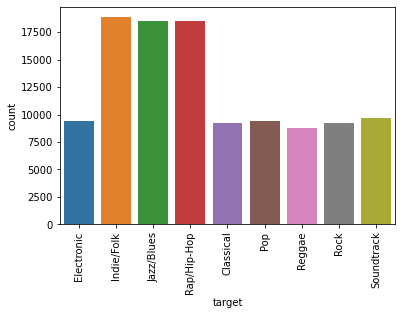

In [34]:
plt.xticks(rotation=90)
sns.countplot(model_df["target"])

# 

# Modelos de classificação


### Logistic Regression

In [35]:
X = model_df.drop("target", 1)
y = model_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state = 42, test_size= 0.3)


# Normalização dos dados quantitativos

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Balanceamento 

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)


# Criando modelo
kf = StratifiedKFold(n_splits = 3, shuffle = True)

lr = LogisticRegression().fit(X_train, y_train)
y_predict = lr.predict(X_test) #normalized_x_test

val = cross_val_score(lr, X_train, y_train, cv=kf)

print("Cross - Val: ", round(val.mean(),2),"%")
print("Accuracy score: ", round(accuracy_score(y_predict, y_test),2),"%")
print("Score: ", round(lr.score(X_test, y_test),2),"%")
print("\n",classification_report(y_predict, y_test))

Cross - Val:  0.49 %
Accuracy score:  0.47 %
Score:  0.47 %

               precision    recall  f1-score   support

   Classical       0.69      0.60      0.64      3167
  Electronic       0.55      0.46      0.50      3379
  Indie/Folk       0.29      0.48      0.36      3441
  Jazz/Blues       0.30      0.52      0.38      3150
         Pop       0.28      0.24      0.25      3280
 Rap/Hip-Hop       0.59      0.64      0.62      5162
      Reggae       0.51      0.33      0.40      4086
        Rock       0.44      0.27      0.33      4644
  Soundtrack       0.76      0.70      0.73      3154

    accuracy                           0.47     33463
   macro avg       0.49      0.47      0.47     33463
weighted avg       0.49      0.47      0.47     33463



In [36]:
result = pd.DataFrame({"P":y_predict,"R":y_test}).tail(20)
result["Acerto/Erro"]= np.where(np.array(result["P"]) == np.array(result["R"]), 1, 0)
result.head()

,P,R,Acerto/Erro
37018,Electronic,Electronic,1
69035,Rap/Hip-Hop,Rap/Hip-Hop,1
114087,Pop,Rap/Hip-Hop,0
200673,Soundtrack,Soundtrack,1
42805,Classical,Indie/Folk,0


# 

## XGBoost

In [37]:
X = model_df.drop("target", 1)
y = model_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state = 42, test_size= 0.3)

le = LabelEncoder()
y_train_le= le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

xgb = XGBClassifier().fit(X_train, y_train_le) 
y_predict = xgb.predict(X_test) 

print("Accuracy score: ", round(accuracy_score(y_predict, y_test_le),2),"%")
print("Score: ", round(xgb.score(X_test, y_test_le),2),"%") 
print("\n",classification_report(y_predict, y_test_le))

Accuracy score:  0.54 %
Score:  0.54 %

               precision    recall  f1-score   support

           0       0.72      0.76      0.74      2644
           1       0.56      0.62      0.59      2536
           2       0.52      0.44      0.48      6788
           3       0.54      0.51      0.53      5871
           4       0.13      0.28      0.18      1345
           5       0.78      0.60      0.68      7249
           6       0.43      0.52      0.47      2160
           7       0.18      0.28      0.22      1843
           8       0.80      0.77      0.78      3027

    accuracy                           0.54     33463
   macro avg       0.52      0.53      0.52     33463
weighted avg       0.59      0.54      0.56     33463



# 

## Neural Network Classifier

In [38]:
X = model_df.drop("target", 1)
y = model_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state = 42, test_size= 0.3)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)

NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1).fit(X_train, y_train)

kf = StratifiedKFold(n_splits = 3, shuffle = True)
y_predict = NN.predict(X_test) 
val = cross_val_score(NN, X_train, y_train, cv=kf)

print("Cross - Val: ", round(val.mean(),2),"%")
print("Accuracy score: ", round(accuracy_score(y_predict, y_test),2),"%")
print("Score: ", round(NN.score(X_test, y_test),2),"%")
print("\n",classification_report(y_predict, y_test))

Cross - Val:  0.5 %
Accuracy score:  0.48 %
Score:  0.48 %

               precision    recall  f1-score   support

   Classical       0.71      0.63      0.67      3138
  Electronic       0.63      0.45      0.53      3969
  Indie/Folk       0.31      0.48      0.38      3665
  Jazz/Blues       0.35      0.52      0.41      3693
         Pop       0.27      0.27      0.27      2798
 Rap/Hip-Hop       0.60      0.66      0.63      5115
      Reggae       0.49      0.35      0.40      3700
        Rock       0.41      0.27      0.32      4214
  Soundtrack       0.78      0.71      0.74      3171

    accuracy                           0.48     33463
   macro avg       0.51      0.48      0.48     33463
weighted avg       0.51      0.48      0.49     33463



# 

# 

# Parte 2 - Testar o modelo para novos dados

## Importar base Projeto Grupo2 

In [39]:
tophits = pd.read_csv("spotify_G2.csv").sort_values("artist",ascending= 0).drop("Unnamed: 0",1)


# 

## Transformação das Variáveis para se adequar às transformações do modelo

In [40]:
tophits_name = tophits.name
tophits = tophits.drop(["name","album","artist","release_date","time_signature", "popularity", "energy", "playlist_year"], 1).copy()
tophits.rename(columns={"length":"duration_ms"}, inplace= True)


testar_grupo2 = tophits.copy()

for i in features_com_skewness:
    if i == "acousticness":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))
    if i == "duration_ms":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))
    if i == "instrumentalness":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))
    if i == "liveness":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: np.log(x))
    if i == "loudness":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: np.log(testar_grupo2.loudness.max()+1-x))
    if i == "speechiness":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: np.log(x))
    if i == "tempo":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))
    if i == "valence":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))
    if i == "danceability":
        testar_grupo2[i] = testar_grupo2[i].swifter.apply(lambda x: x**(1/3))


#testar_grupo2 = testar_grupo2[["acousticness","danceability","duration_ms","instrumentalness","liveness","loudness","speechiness","tempo","valence"]].copy()
tophits = testar_grupo2[["acousticness","danceability","duration_ms","instrumentalness","liveness","loudness","speechiness","tempo"]].copy()



# 

## Prevendo resultados

In [41]:
X_semvalence = X.drop("valence", 1)

X_train, X_test, y_train, y_test = train_test_split(X_semvalence, y,stratify=y, random_state = 42, test_size= 0.3)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_semvalence.columns)
X_test = pd.DataFrame(scaler.transform(tophits), columns = tophits.columns)

lr = LogisticRegression().fit(X_train, y_train)

y_predict = lr.predict(X_test)

Resultado = pd.DataFrame({"track_name": tophits_name, "Predicted": y_predict})

In [42]:
Resultado

,track_name,Predicted
966,#thatPOWER,Pop
930,Scream & Shout,Rap/Hip-Hop
153,All The Things She Said,Pop
872,We Are Young (feat. Janelle Monáe),Pop
226,I Miss You,Rock
...,...,...
1237,Bank Account,Rap/Hip-Hop
962,We Own It (Fast & Furious),Rap/Hip-Hop
41,It's Gonna Be Me,Pop
27,Bye Bye Bye,Pop


# 

# 